In [1]:
import numpy as np
from flet.matplotlib_chart import MatplotlibChart
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import flet as ft
from sympy import sympify, lambdify
import nest_asyncio
from sympy.abc import x
nest_asyncio.apply()

In [2]:
def string_to_function(expression):
    if 'x' not in expression:
        # here we say that the expression in input has to contain the variable x
        raise SyntaxError("Error: The function must include the variable 'x'. Example: '1/(x^2+1)'")
    try: 
        sympy_expr = sympify(expression)  # with the sympify() function we convert the string into a symbolic mathematical expression
        
        f = lambdify(x, sympy_expr, modules=["numpy"]) # with lambdify() we convert the mathematical expression into a python expression
    except Exception: 
        raise SyntaxError('Error: Please enter a correct function, as 1/(x^2+1)')
    return f  #  we convert it to a Python function

def read_range(range_text):
    # we check to see if the range text is empty or not
    if not range_text:
        raise AttributeError('Error: Please enter a range')
    nums = range_text.split(",")

    # the range is defined by two numbers separated by a comma, this is what we check below
    if len(nums) != 2:
        raise TypeError('Error: Invalid range. Use two integer values separated by a comma')
    
    try:
        # convert both values to floats
        a, b = float(nums[0].strip()), float(nums[1].strip())
    except ValueError:
        # in case someone tries to insert a string or something else insead of a float number as a range
        raise TypeError('Error: Invalid range. Use two numerical values separated by a comma')
    
    if a >= b:
        raise ValueError('Error: The first number must be lower than the second')

    return a, b

def check_function_defined_nonnegative(pdf_function, a, b):
    # Check if the function is well-defined within the range [a, b]
    x_values = np.linspace(a, b, 1000)
    y_values = pdf_function(x_values)
    if np.any(np.isnan(y_values)) or np.any(np.isinf(y_values)):
        raise ValueError("The function is not defined in the given range.")
    
    # we also check that the function is non-negative in the given range, so it can be considered as a valid PDF.
    if np.any(y_values < 0):
        raise ValueError("The function is negative in the given range, so it cannot be a valid PDF.")

# function that we can use tu normalize our pdf
def normalize_pdf(pdf_function, a, b):
    check_function_defined_nonnegative(pdf_function, a, b)
    area, _ = integrate.quad(pdf_function, a, b)
    return lambda x: pdf_function(x) / area

def differential_entropy(pdf_function, a, b):
    # with the integrand() function we define the function that needs to be integrated in order to compute the differential entropy
    def integrand(x):
        fx = pdf_function(x)
        if fx <= 0:  # Avoid log(0) 
            return 0
        return -fx * np.log2(fx)
    
    result, _ = integrate.quad(integrand, a, b)
    return result

def main(page: ft.Page):
    page.title = 'Exercise 1 - Part B'
    page.window.width = 750
    page.window.height = 450


    # the compute() function is called when we run the code, and also when we change the input values and the "blur" them -- see later
    def compute(e = None):
        diff_entr.value = ""
        chart_column.controls = []
        dis = distrib.value
        ran = rangev.value
        # we don't go on with the function if the distribution field or the range field is empty
        if not dis or not ran:
            return 
        
        try:
            a, b = read_range(ran)
            pdf_function = string_to_function(dis)

            normalized_pdf = normalize_pdf(pdf_function, a, b)
            # I double check also the normalized pdf.
            check_function_defined_nonnegative(normalized_pdf, a, b)

            # Compute differential entropy on the normalized pdf
            d_ent = differential_entropy(normalized_pdf, a, b)
            diff_entr.value = f"{d_ent:.6f}"  # Display result, and we approximate it

            # Clear previous chart in the chart column
            chart_column.controls.clear()

            # here we build the plot of the pdf over the range
            x = np.linspace(a, b, 1000)
            y = np.array([normalized_pdf(x_i) for x_i in x])
            fig, ax = plt.subplots()
            ax.plot(x, y)
            ax.set(xlabel='x', ylabel='f_X(x)')
            chart = MatplotlibChart(fig)
            chart_column.controls.append(chart)

            errors.value = ""
        except Exception as ex:
            # add errors if occure
            errors.value = str(ex)

        page.update()

    # UI Setup
    page.add(ft.Text('Differential Entropy Calculator', width=750, height=50, 
                     text_align=ft.TextAlign.CENTER, weight=ft.FontWeight.BOLD, size=20))

    distrib = ft.TextField(width=150, expand=True, on_blur=compute, value="1/(x^2+1)") # every time we write something into the textfield and then click somewhere else, the compute function is called
    rangev = ft.TextField(width=150, on_blur=compute, value="0,10")
    diff_entr = ft.TextField(width=150, read_only=True)
    exit_button = ft.ElevatedButton("EXIT", on_click=lambda e: page.window.close())

    # Input Column
    r1 = ft.Row(controls=[ft.Text('f_X(x) proportional to:'), distrib], expand=True,height=50, alignment=ft.MainAxisAlignment.END)
    r2 = ft.Row(controls=[ft.Text('Range of x'), rangev], height=50, alignment=ft.MainAxisAlignment.END)
    r3 = ft.Row(controls=[ft.Text('Differential entropy ='), diff_entr], height=50, alignment=ft.MainAxisAlignment.END)
    r4 = ft.Row(controls=[exit_button], alignment=ft.MainAxisAlignment.CENTER)
    input_column = ft.Column(controls=[r1, r2, r3, r4], horizontal_alignment=ft.MainAxisAlignment.START, spacing=10)

    # Chart Column
    chart_column = ft.Column(spacing=10, expand=True)  # Empty initially; chart will be added after computation

    main_row = ft.Row(
        controls=[
            ft.Container(content=input_column, expand=3),
            ft.Container(content=chart_column, expand=4)
        ],
        alignment=ft.MainAxisAlignment.CENTER
    )

    page.add(main_row)
    errors = ft.Text(color="red")  # Error message area
    page.add(errors)

    compute()

    page.update()



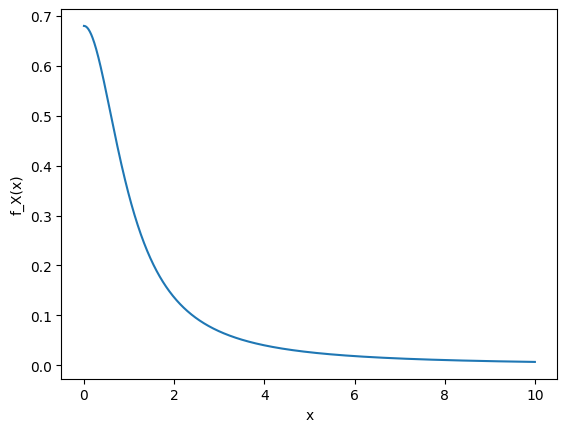

In [7]:
# Run the app
# Works only on Windows 11 and macOS. If using Windows 10, comment this line and use the web browser option below.
ft.app(target=main, view=ft.AppView.FLET_APP)

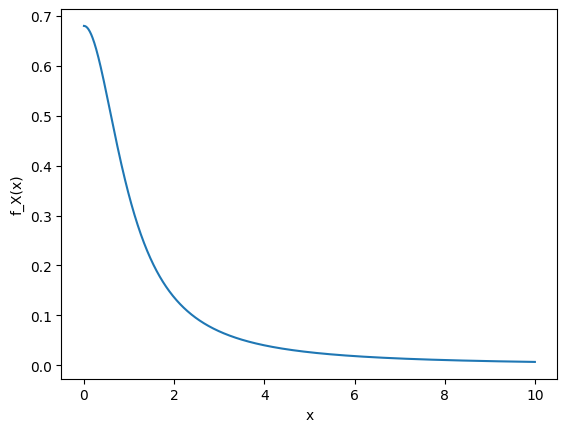

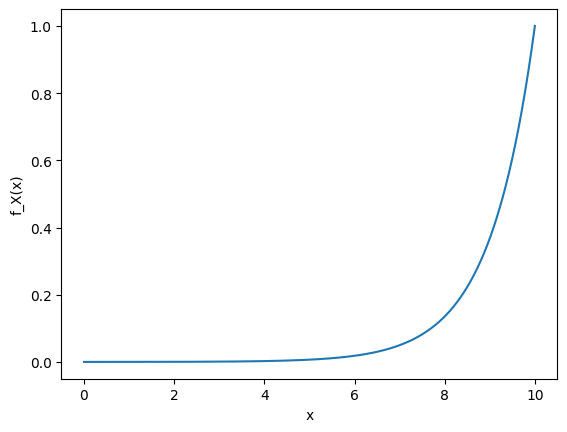

In [ ]:
# Works on all operating systems, including Windows 10. Uncomment this line if using Windows 10 and comment the pop-up window option.
#ft.app(target=main, view=ft.AppView.WEB_BROWSER)